# Dados Segurança Pública Rio de Janeiro

O presente projeto tem como objetivo fazer uma análise dos dados de segurança pública do Estado do Rio de Janeiro apresentados no website http://www.ispdados.rj.gov.br/estatistica.html. Abaixo está o dicionário das variáveis:
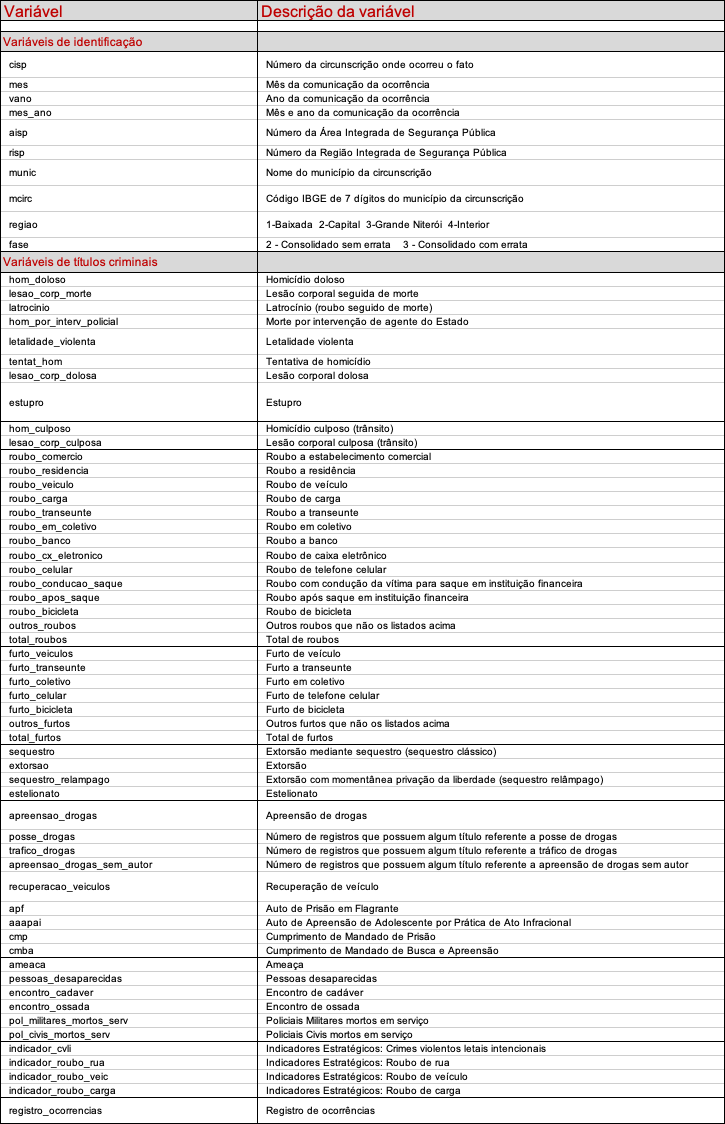

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from itertools import chain
import pandas as pd
import seaborn as sns
import random
import functions as fn
import warnings
warnings.filterwarnings("ignore")
random.seed(999)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import geospaitial libraries
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Read data
data = pd.read_csv("BaseDPEvolucaoMensalCisp.csv"
                   ,encoding='latin-1'
                   ,header=0
                   ,sep=';'
                   ,low_memory=False
                  )
data.head()

,CISP,mes,vano,mes_ano,AISP,RISP,munic,mcirc,Regiao,hom_doloso,lesao_corp_morte,latrocinio,hom_por_interv_policial,letalidade_violenta,tentat_hom,lesao_corp_dolosa,estupro,hom_culposo,lesao_corp_culposa,roubo_comercio,roubo_residencia,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,roubo_cx_eletronico,roubo_celular,roubo_conducao_saque,roubo_apos_saque,roubo_bicicleta,outros_roubos,total_roubos,furto_veiculos,furto_transeunte,furto_coletivo,furto_celular,furto_bicicleta,outros_furtos,total_furtos,sequestro,extorsao,sequestro_relampago,estelionato,apreensao_drogas,posse_drogas,trafico_drogas,apreensao_drogas_sem_autor,recuperacao_veiculos,apf,aaapai,cmp,cmba,ameaca,pessoas_desaparecidas,encontro_cadaver,encontro_ossada,pol_militares_mortos_serv,pol_civis_mortos_serv,indicador_cvli,indicador_roubo_rua,indicador_roubo_veic,indicador_roubo_carga,registro_ocorrencias,fase
0,1,1,2003,2003m1,5,1,Rio de Janeiro,3304557,Capital,0,0,0,0,0,1,40,0,1,15,14,0,5,1,26,8,0,0,32,0,10,,4,100,12,30,0,37,,90,169,0,1,0,69,1,,,,5,,,,,21,2,0,0,0,0,0,66,5,1,578,3
1,4,1,2003,2003m1,5,1,Rio de Janeiro,3304557,Capital,3,0,0,0,3,0,47,1,4,35,5,0,9,1,25,12,0,1,14,1,3,,11,82,9,42,5,23,,36,115,0,1,0,1,35,,,,7,,,,,15,6,0,1,0,0,3,51,9,1,441,3
2,5,1,2003,2003m1,5,1,Rio de Janeiro,3304557,Capital,3,0,0,0,3,1,73,2,1,19,10,1,11,5,26,4,2,0,34,2,4,,24,123,28,42,2,47,,97,216,0,0,0,37,4,,,,10,,,,,47,2,1,0,0,0,3,64,11,5,637,3
3,6,1,2003,2003m1,1,1,Rio de Janeiro,3304557,Capital,6,0,0,0,6,2,43,2,1,20,10,0,27,6,14,22,0,0,20,0,6,,38,143,17,4,0,8,,61,90,0,0,0,8,20,,,,77,,,,,26,2,1,0,0,0,6,56,27,6,473,3
4,7,1,2003,2003m1,1,1,Rio de Janeiro,3304557,Capital,4,0,0,0,4,2,18,2,0,2,0,2,23,1,4,0,0,0,1,0,1,,23,55,12,1,0,1,,21,35,0,0,0,4,3,,,,9,,,,,10,1,3,0,0,0,4,5,23,1,147,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27313 entries, 0 to 27312
Data columns (total 65 columns):
CISP                          27313 non-null int64
mes                           27313 non-null int64
vano                          27313 non-null int64
mes_ano                       27313 non-null object
AISP                          27313 non-null int64
RISP                          27313 non-null int64
munic                         27313 non-null object
mcirc                         27313 non-null int64
Regiao                        27313 non-null object
hom_doloso                    27313 non-null int64
lesao_corp_morte              27313 non-null int64
latrocinio                    27313 non-null int64
hom_por_interv_policial       27313 non-null int64
letalidade_violenta           27313 non-null int64
tentat_hom                    27313 non-null int64
lesao_corp_dolosa             27313 non-null int64
estupro                       27313 non-null int64
hom_culposo          

In [4]:
# Corrigindo algumas variáveis para inteiro
for column in data.columns:
    if data[column].dtype == 'O' and \
    column not in ('mes_ano','munic','Regiao'):
        data[column].replace(' ', '0', inplace=True)
        data[column] = data[column].astype(int)
    if column in ('munic','Regiao'):
        data[column] = data[column].str.strip()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27313 entries, 0 to 27312
Data columns (total 65 columns):
CISP                          27313 non-null int64
mes                           27313 non-null int64
vano                          27313 non-null int64
mes_ano                       27313 non-null object
AISP                          27313 non-null int64
RISP                          27313 non-null int64
munic                         27313 non-null object
mcirc                         27313 non-null int64
Regiao                        27313 non-null object
hom_doloso                    27313 non-null int64
lesao_corp_morte              27313 non-null int64
latrocinio                    27313 non-null int64
hom_por_interv_policial       27313 non-null int64
letalidade_violenta           27313 non-null int64
tentat_hom                    27313 non-null int64
lesao_corp_dolosa             27313 non-null int64
estupro                       27313 non-null int64
hom_culposo          

Agruparemos alguns tipos de crime conforme a espécie de cada um a fim de facilitar algumas análises

In [5]:
data['violentos'] = data.hom_doloso + \
                    data.lesao_corp_morte + \
                    data.latrocinio + \
                    data.hom_por_interv_policial + \
                    data.letalidade_violenta + \
                    data.tentat_hom + \
                    data.lesao_corp_dolosa + \
                    data.estupro
                    
data['transito'] = data.hom_culposo + data.lesao_corp_culposa

data['outros_ctra_patr'] = data.sequestro + \
                           data.extorsao + \
                           data.sequestro_relampago + \
                           data.estelionato
data['drogas'] = data.apreensao_drogas + \
                 data.posse_drogas + \
                 data.trafico_drogas + \
                 data.apreensao_drogas_sem_autor

Para conhecermos um pouco a base de dados, utilizaremos ferramentas de estatística descritiva.

In [6]:
data.describe()

,CISP,mes,vano,AISP,RISP,mcirc,hom_doloso,lesao_corp_morte,latrocinio,hom_por_interv_policial,letalidade_violenta,tentat_hom,lesao_corp_dolosa,estupro,hom_culposo,lesao_corp_culposa,roubo_comercio,roubo_residencia,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,roubo_cx_eletronico,roubo_celular,roubo_conducao_saque,roubo_apos_saque,roubo_bicicleta,outros_roubos,total_roubos,furto_veiculos,furto_transeunte,furto_coletivo,furto_celular,furto_bicicleta,outros_furtos,total_furtos,sequestro,extorsao,sequestro_relampago,estelionato,apreensao_drogas,posse_drogas,trafico_drogas,apreensao_drogas_sem_autor,recuperacao_veiculos,apf,aaapai,cmp,cmba,ameaca,pessoas_desaparecidas,encontro_cadaver,encontro_ossada,pol_militares_mortos_serv,pol_civis_mortos_serv,indicador_cvli,indicador_roubo_rua,indicador_roubo_veic,indicador_roubo_carga,registro_ocorrencias,fase,violentos,transito,outros_ctra_patr,drogas
count,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,2.731300e+04,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000,27313.000000
mean,81.711493,6.503313,2011.127888,19.923699,3.870428,3.809670e+06,3.294951,0.027935,0.111449,0.611138,4.045473,3.013730,47.585106,2.776956,1.451031,24.195621,3.635814,0.923553,20.422949,3.345513,38.142826,5.937649,0.018855,0.026434,7.420166,0.084209,1.080584,0.029400,11.092923,92.160876,11.487094,15.666056,4.853330,10.840332,0.343939,55.270933,98.461685,0.004723,0.995277,0.058031,16.894775,10.765460,3.769963,4.691649,1.139677,15.535862,14.332076,3.483213,7.777505,0.534214,43.178340,3.253469,0.410500,0.024311,0.015560,0.002490,3.434335,51.500641,20.422949,3.345513,432.107128,2.984952,61.466737,25.646652,17.952806,20.366748
std,48.310807,3.452084,4.888544,11.317871,2.013215,1.769922e+06,4.735343,0.180890,0.400129,1.547042,5.661854,4.145467,44.442057,3.577809,1.964040,24.016859,4.437536,1.382510,34.633385,7.678439,54.485780,11.208270,0.143101,0.174212,13.107122,0.350136,2.056677,0.221285,17.793227,126.820066,14.307934,32.872582,8.002056,16.002605,1.382969,52.797256,106.088689,0.076632,1.675734,0.342027,22.574802,13.929875,8.922221,7.208500,2.469573,26.035422,17.390020,5.770422,15.543445,1.588788,41.218636,4.085559,0.876979,0.190759,0.142472,0.051993,4.859133,73.145172,34.633385,7.678439,384.810638,0.121745,57.373650,24.997729,23.551978,27.574809
min,1.000000,1.000000,2003.000000,1.000000,1.000000,3.300100e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,4.000000,2007.000000,10.000000,2.000000,3.302700e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,14.000000,

In [7]:
# Número de circunscrições diferentes
for i in range(2006,2020,1):
    print(f'Número de circunscrições diferentes no ano {i}: {len(data[data.vano==i].CISP.unique())}')
    print(f'Número de áreas integradas diferentes no ano {i}: {len(data[data.vano==i].AISP.unique())}')
    print(f'Número de regiões integradas diferentes no ano {i}: {len(data[data.vano==i].RISP.unique())}\n')

Número de circunscrições diferentes no ano 2006: 130
Número de áreas integradas diferentes no ano 2006: 40
Número de regiões integradas diferentes no ano 2006: 7

Número de circunscrições diferentes no ano 2007: 130
Número de áreas integradas diferentes no ano 2007: 40
Número de regiões integradas diferentes no ano 2007: 7

Número de circunscrições diferentes no ano 2008: 131
Número de áreas integradas diferentes no ano 2008: 40
Número de regiões integradas diferentes no ano 2008: 7

Número de circunscrições diferentes no ano 2009: 131
Número de áreas integradas diferentes no ano 2009: 40
Número de regiões integradas diferentes no ano 2009: 7

Número de circunscrições diferentes no ano 2010: 133
Número de áreas integradas diferentes no ano 2010: 40
Número de regiões integradas diferentes no ano 2010: 7

Número de circunscrições diferentes no ano 2011: 136
Número de áreas integradas diferentes no ano 2011: 41
Número de regiões integradas diferentes no ano 2011: 7

Número de circunscriçõ

Avaliaremos apenas o período de Jan/2013 até Dez/2019 por não haver registros para algumas espécies de crimes antes desta data e porque o número de áreas integradas ficou mais estável neste período.

In [8]:
data = data[data.vano >= 2013]
data['mesano'] = data.vano*100 + data.mes
data.index = data.mesano
data.vano.describe()

count    11558.000000
mean      2016.002596
std          1.996404
min       2013.000000
25%       2014.000000
50%       2016.000000
75%       2018.000000
max       2019.000000
Name: vano, dtype: float64

In [9]:
# Bases cartográficas retiradas do site http://www.ispdados.rj.gov.br/Conteudo.html

#rj_geo_dp = gpd.read_file('bases_cartograficas/shape_limites_seg_CISP/lm_dp_2019.shp')
#rj_geo_risp = gpd.read_file('bases_cartograficas/RISPshp/Limite_RISP_WGS.shp')
rj_geo_aisp = gpd.read_file('bases_cartograficas/AISPshp/lm_aisp_2019.shp')

In [10]:
rj_geo_aisp

,aisp,objectid_1,risp,aisp_1,naisp,st_area_sh,st_length_,geometry
0,2,30,1,2,2,0.001323,0.379879,"MULTIPOLYGON (((-43.16114 -22.95715, -43.16112..."
1,3,39,1,3,3,0.003433,0.318484,"POLYGON ((-43.28825 -22.85901, -43.28832 -22.8..."
2,4,32,1,4,4,0.001509,0.402028,"MULTIPOLYGON (((-43.20988 -22.86702, -43.20778..."
3,5,31,1,5,5,0.001357,0.620828,"MULTIPOLYGON (((-43.18095 -22.89546, -43.18082..."
4,6,29,1,6,6,0.004857,0.464405,"POLYGON ((-43.20880 -22.90988, -43.20844 -22.9..."
5,7,5,4,7,7,0.021790,0.807171,"MULTIPOLYGON (((-42.99362 -22.73849, -42.99396..."
6,8,14,6,8,8,0.579078,5.323202,"POLYGON ((-41.37820 -21.19574, -41.37689 -21.1..."
7,9,38,2,9,9,0.002961,0.331278,"POLYGON ((-43.34671 -22.82823, -43.34589 -22.8..."
8,10,7,5,10,10,0.372059,4.906962,"POLYGON ((-43.58350 -22.05580, -43.58338 -22.0..."
9,11,15,7,11,11,0.353640,4.975308,"POLYGON ((-42.23757 -21.69837, -42.22761 -21.7..."


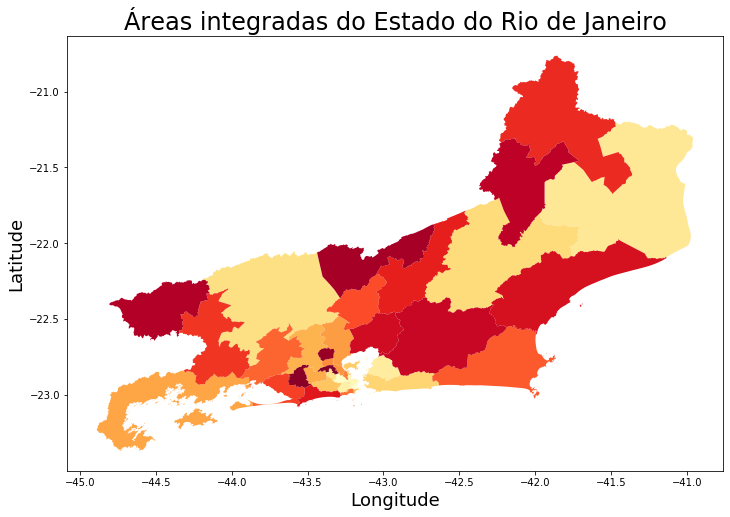

In [11]:
# Mapa do Estado do Rio de Janeiro
fig, ax = plt.subplots(figsize=(16,8))
rj_geo_aisp.plot(ax=ax, cmap='YlOrRd', legend=True)
ax.set_title('Áreas integradas do Estado do Rio de Janeiro', fontsize=24)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.savefig('AreasIntegradas')
plt.show();

In [12]:
sem_duplicados = data[['Regiao','AISP']].drop_duplicates(subset=['Regiao','AISP'])
sem_duplicados.columns = ['Regiao', 'aisp']
rj_geo_aisp = rj_geo_aisp.merge(sem_duplicados, how='left', on='aisp')

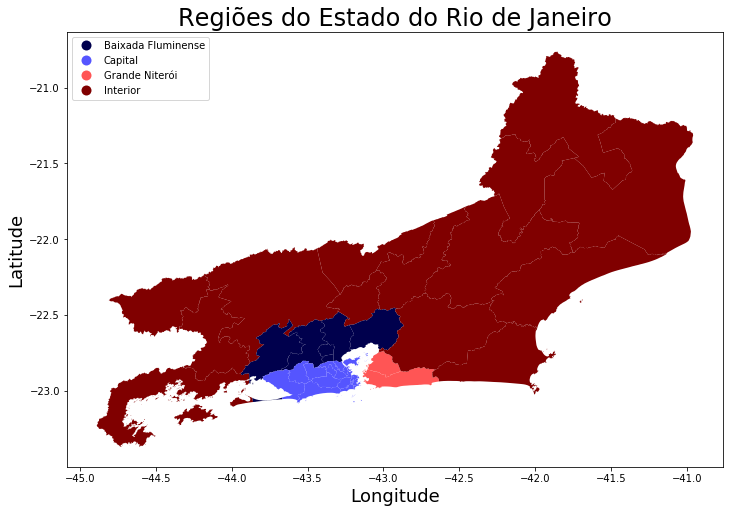

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
rj_geo_aisp.plot(ax=ax, column='Regiao', cmap='seismic', legend=True, legend_kwds=dict(loc='upper left', bbox_to_anchor=(0, 1)))
ax.set_title('Regiões do Estado do Rio de Janeiro', fontsize=24)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.savefig('Regiões')
plt.show();

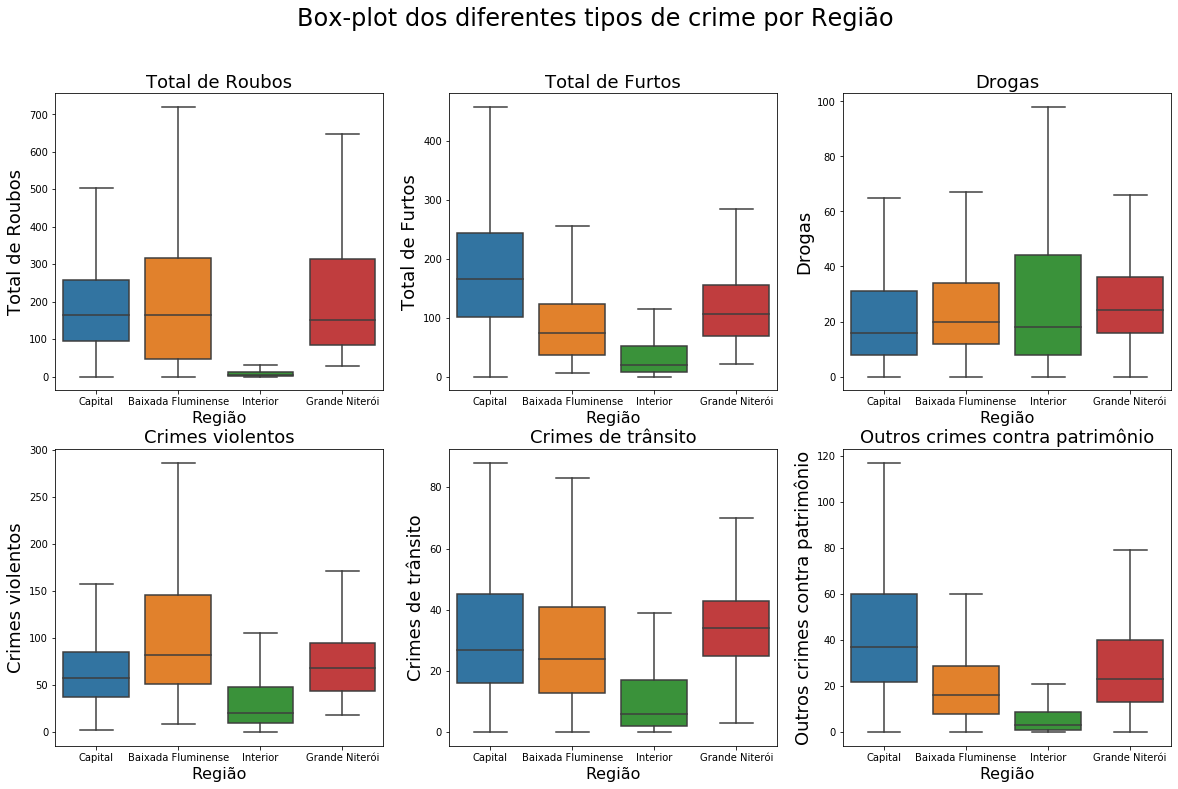

In [14]:
colunas = ['total_roubos','total_furtos','drogas','violentos','transito','outros_ctra_patr']
ylabel = ['Total de Roubos', 'Total de Furtos', 'Drogas', 'Crimes violentos', 'Crimes de trânsito', 'Outros crimes contra patrimônio' ]
nrows = 2
ncols = 3
k=0
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
plt.suptitle('Box-plot dos diferentes tipos de crime por Região',fontsize=24)
for i in range(nrows):
    for j in range(ncols):
        sns.boxplot(x="Regiao", y=colunas[k], data=data, ax=ax[i,j], showfliers=False)
        ax[i,j].set_ylabel(ylabel[k],fontsize=18)
        ax[i,j].set_title(ylabel[k],fontsize=18)
        ax[i,j].set_xlabel('Região',fontsize=16)
        k += 1
plt.savefig('boxplot')


In [15]:
total_roubos = ['roubo_comercio',
          'roubo_residencia',
          'roubo_veiculo',
          'roubo_carga',
          'roubo_transeunte',
          'roubo_em_coletivo',
          'roubo_banco',
          'roubo_cx_eletronico',
          'roubo_celular',
          'roubo_conducao_saque',
          'roubo_apos_saque',
          'roubo_bicicleta',
          'outros_roubos']

total_furtos = ['furto_veiculos',
          'furto_transeunte',
          'furto_coletivo',
          'furto_celular',
          'furto_bicicleta',
          'outros_furtos']

violentos = ['hom_doloso',
             'lesao_corp_morte',
             'latrocinio',
             'hom_por_interv_policial',
             'letalidade_violenta',
             'tentat_hom',
             'lesao_corp_dolosa',
             'estupro']
                    
transito = ['hom_culposo','lesao_corp_culposa']

outros_ctra_patr = ['sequestro',
                    'extorsao',
                    'sequestro_relampago',
                    'estelionato']
drogas = ['apreensao_drogas',
          'posse_drogas',
          'trafico_drogas',
          'apreensao_drogas_sem_autor']

In [16]:
# Fazendo a Pivot-Table para colocar os crimes em uma única coluna
dict_por_crime = {}
for name in colunas:
    dict_por_crime[name] = data.pivot_table(values=eval(name), 
                        index=[data.Regiao, data.vano], 
                        aggfunc=sum)
    dict_por_crime[name] = pd.DataFrame(dict_por_crime[name].stack(), columns=['Total']) 

# Acumulando a soma dos crimes por ano, pois o seaborn não tem uma função built-in para gráfico de barras empilhado
for i in dict_por_crime.keys():
    dict_por_crime[i]["Cumsum"] = dict_por_crime[i].groupby(level=["Regiao", "vano"]).cumsum()
    dict_por_crime[i].reset_index(inplace=True)
    dict_por_crime[i].rename(columns={"level_2": "tipo_crime"}, inplace=True)

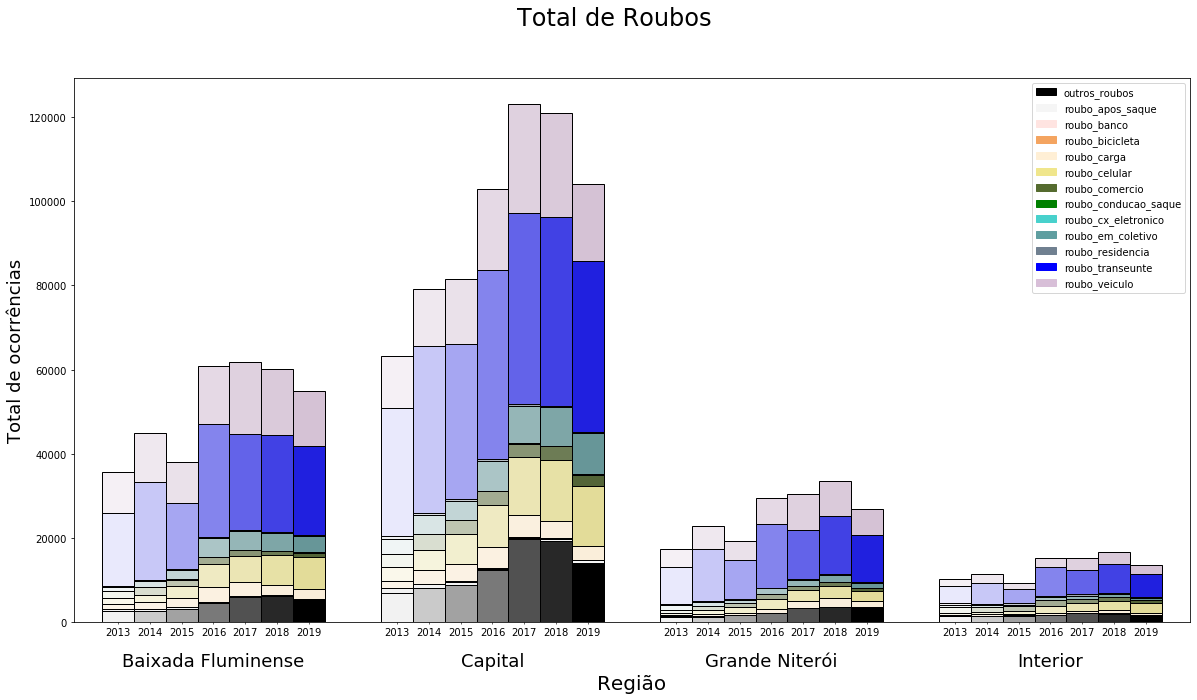

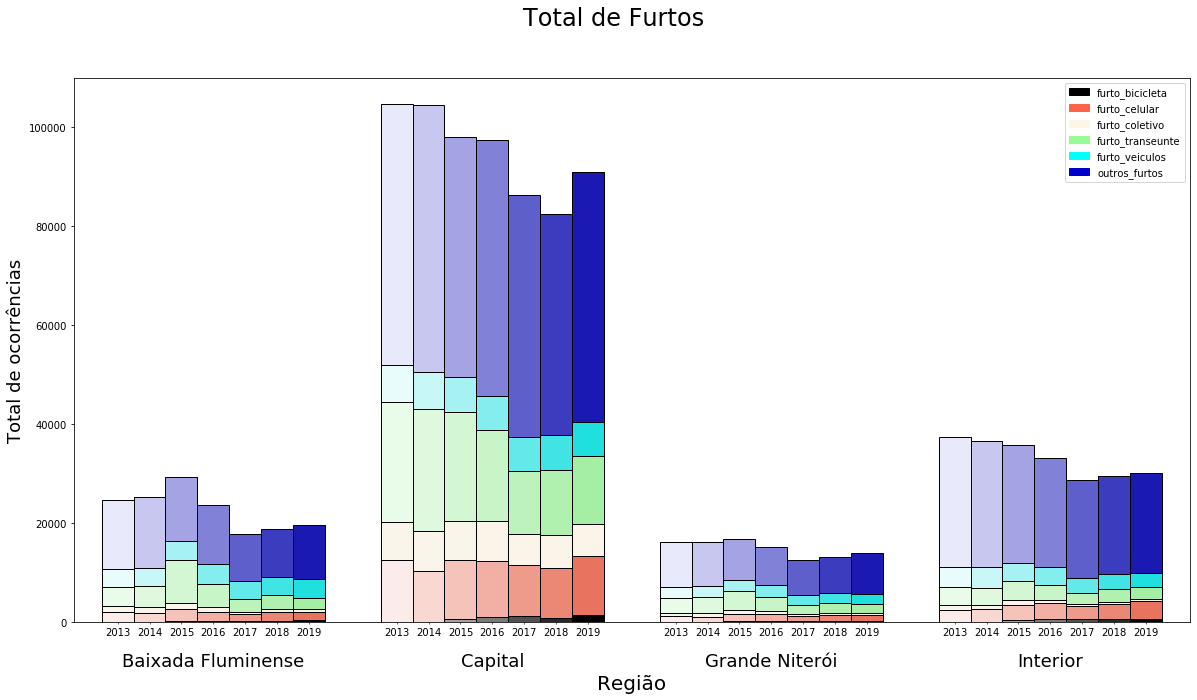

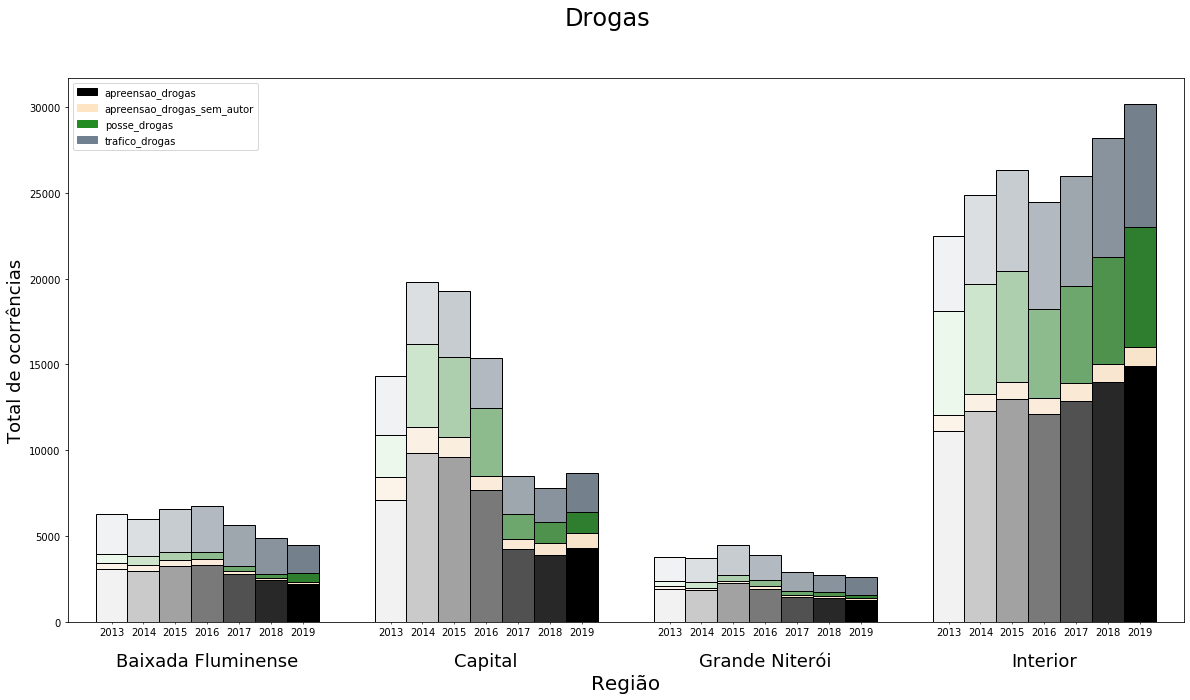

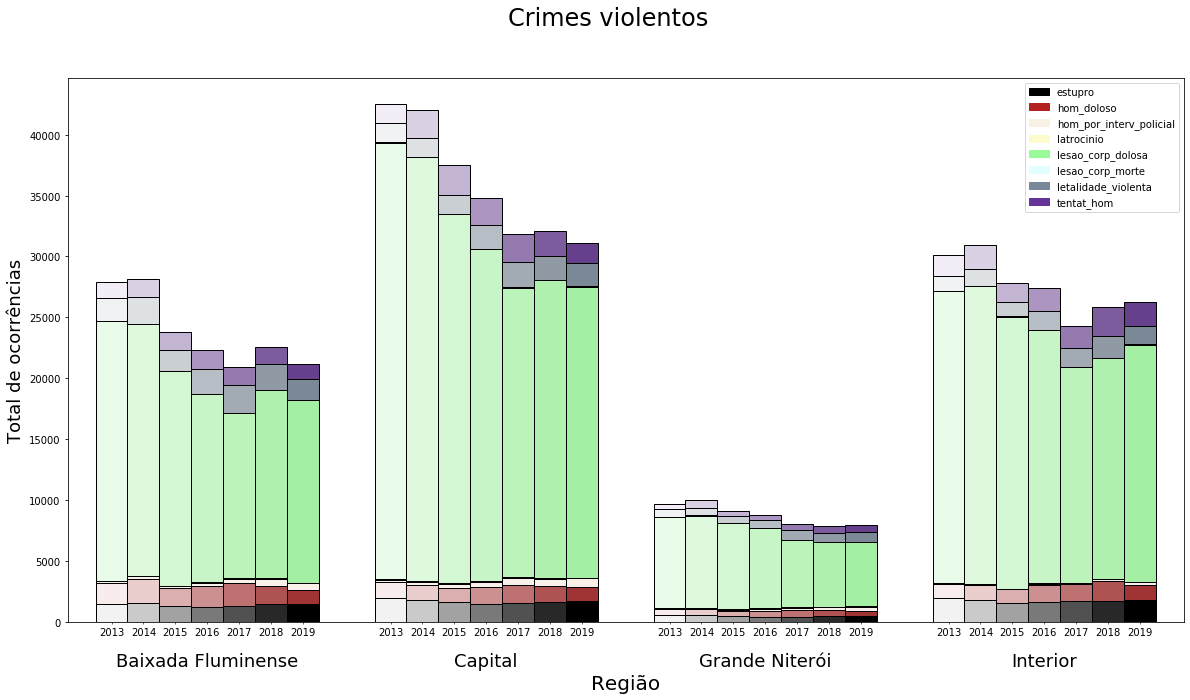

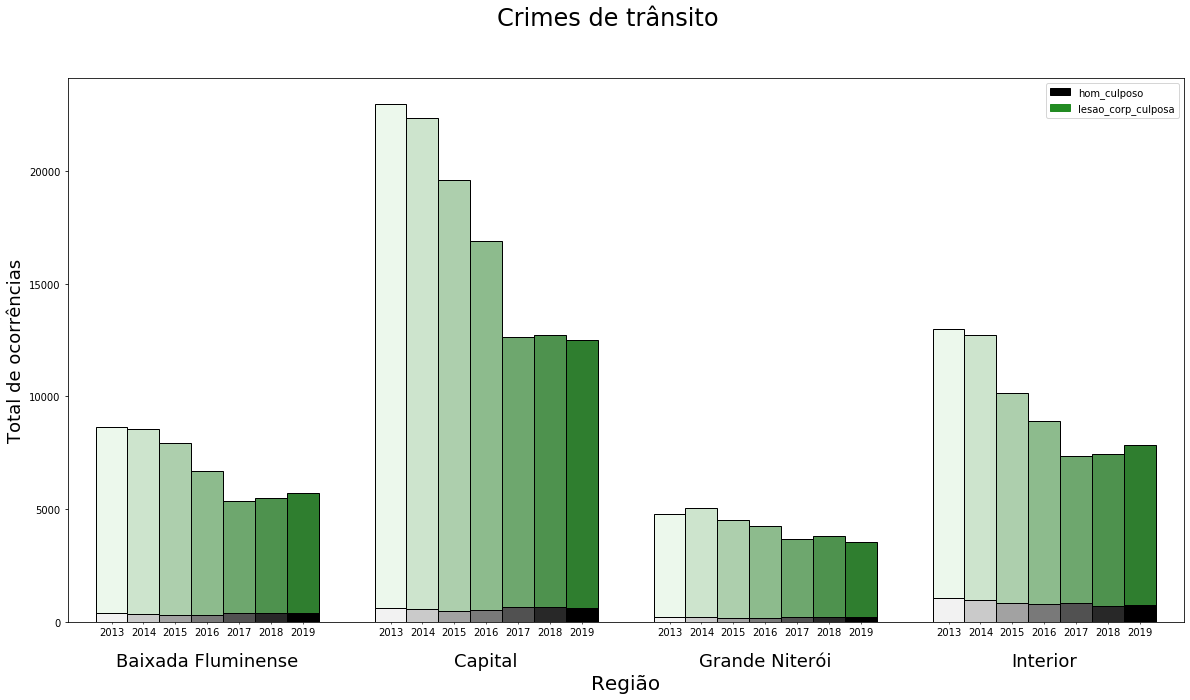

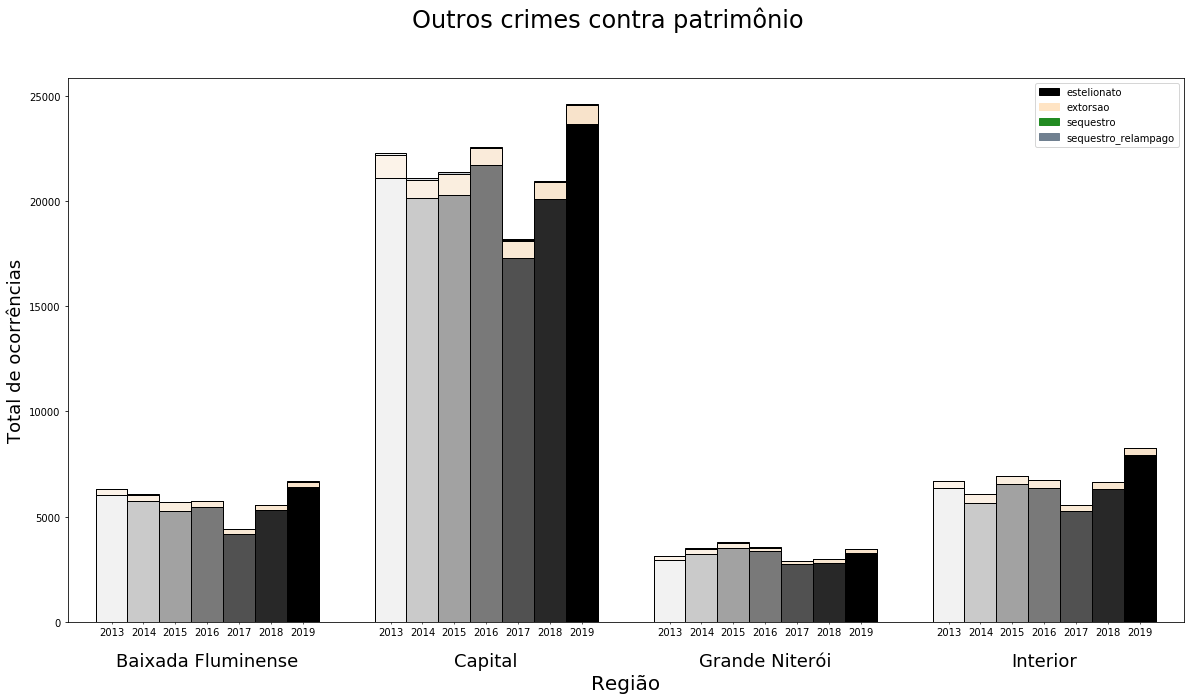

In [17]:
i=0
for k in dict_por_crime.keys():
    fn.draw_grouped_stacked_bars(dict_por_crime, k, suptitle=ylabel[i], file_name=str(k+'.png'))
    i += 1

In [18]:
dict_por_crime['violentos']

,Regiao,vano,tipo_crime,Total,Cumsum
0,Baixada Fluminense,2013,estupro,1487,1487
1,Baixada Fluminense,2013,hom_doloso,1724,3211
2,Baixada Fluminense,2013,hom_por_interv_policial,108,3319
3,Baixada Fluminense,2013,latrocinio,46,3365
4,Baixada Fluminense,2013,lesao_corp_dolosa,21317,24682
5,Baixada Fluminense,2013,lesao_corp_morte,3,24685
6,Baixada Fluminense,2013,letalidade_violenta,1881,26566
7,Baixada Fluminense,2013,tentat_hom,1330,27896
8,Baixada Fluminense,2014,estupro,1565,1565
9,Baixada Fluminense,2014,hom_doloso,1968,3533


In [19]:
# Selecionando apenas os totais para normalizamos e verificar qual o tipo de crime menos/mais incidente em cada AISP
df_totais_AISP = data.pivot_table(values=colunas, 
                        index=[data.AISP, data.vano], 
                        aggfunc=sum)
df_totais_AISP.reset_index(inplace=True)

In [20]:
df_totais_AISP_2019 = df_totais_AISP[df_totais_AISP.vano==2019]
for i in colunas:
    df_totais_AISP_2019[[i]] = (df_totais_AISP_2019[[i]] - df_totais_AISP_2019[[i]].min())/(df_totais_AISP_2019[[i]].max()-df_totais_AISP_2019[[i]].min())
    df_totais_AISP_2019.rename(columns={"AISP": "aisp"}, inplace=True)

In [21]:
df_totais_AISP_2013 = df_totais_AISP[df_totais_AISP.vano==2013]
for i in colunas:
    df_totais_AISP_2013[[i]] = (df_totais_AISP_2013[[i]] - df_totais_AISP_2013[[i]].min())/(df_totais_AISP_2013[[i]].max()-df_totais_AISP_2013[[i]].min())
df_totais_AISP_2013.rename(columns={"AISP": "aisp"}, inplace=True)
df_totais_AISP_2013.head()

,aisp,vano,drogas,outros_ctra_patr,total_furtos,total_roubos,transito,violentos
0,2,2013,0.068401,0.442623,0.412614,0.226473,0.201964,0.024997
7,3,2013,0.342275,0.647541,0.506161,0.579751,0.690436,0.320063
14,4,2013,0.290504,0.349851,0.377907,0.295851,0.605465,0.166248
21,5,2013,0.403702,1.000000,1.000000,0.464813,0.396670,0.158841
28,6,2013,0.207886,0.487332,0.275684,0.163154,0.149018,0.093109


In [22]:
rj_geo_aisp.head()

,aisp,objectid_1,risp,aisp_1,naisp,st_area_sh,st_length_,geometry,Regiao
0,2,30,1,2,2,0.001323,0.379879,"MULTIPOLYGON (((-43.16114 -22.95715, -43.16112...",Capital
1,3,39,1,3,3,0.003433,0.318484,"POLYGON ((-43.28825 -22.85901, -43.28832 -22.8...",Capital
2,4,32,1,4,4,0.001509,0.402028,"MULTIPOLYGON (((-43.20988 -22.86702, -43.20778...",Capital
3,5,31,1,5,5,0.001357,0.620828,"MULTIPOLYGON (((-43.18095 -22.89546, -43.18082...",Capital
4,6,29,1,6,6,0.004857,0.464405,"POLYGON ((-43.20880 -22.90988, -43.20844 -22.9...",Capital


In [23]:
rj_geo_aisp_2013 = rj_geo_aisp.merge(df_totais_AISP_2013, how='left', on='aisp')
rj_geo_aisp_2019 = rj_geo_aisp.merge(df_totais_AISP_2019, how='left', on='aisp')
rj_geo_aisp_2013.head()

,aisp,objectid_1,risp,aisp_1,naisp,st_area_sh,st_length_,geometry,Regiao,vano,drogas,outros_ctra_patr,total_furtos,total_roubos,transito,violentos
0,2,30,1,2,2,0.001323,0.379879,"MULTIPOLYGON (((-43.16114 -22.95715, -43.16112...",Capital,2013,0.068401,0.442623,0.412614,0.226473,0.201964,0.024997
1,3,39,1,3,3,0.003433,0.318484,"POLYGON ((-43.28825 -22.85901, -43.28832 -22.8...",Capital,2013,0.342275,0.647541,0.506161,0.579751,0.690436,0.320063
2,4,32,1,4,4,0.001509,0.402028,"MULTIPOLYGON (((-43.20988 -22.86702, -43.20778...",Capital,2013,0.290504,0.349851,0.377907,0.295851,0.605465,0.166248
3,5,31,1,5,5,0.001357,0.620828,"MULTIPOLYGON (((-43.18095 -22.89546, -43.18082...",Capital,2013,0.403702,1.000000,1.000000,0.464813,0.396670,0.158841
4,6,29,1,6,6,0.004857,0.464405,"POLYGON ((-43.20880 -22.90988, -43.20844 -22.9...",Capital,2013,0.207886,0.487332,0.275684,0.163154,0.149018,0.093109


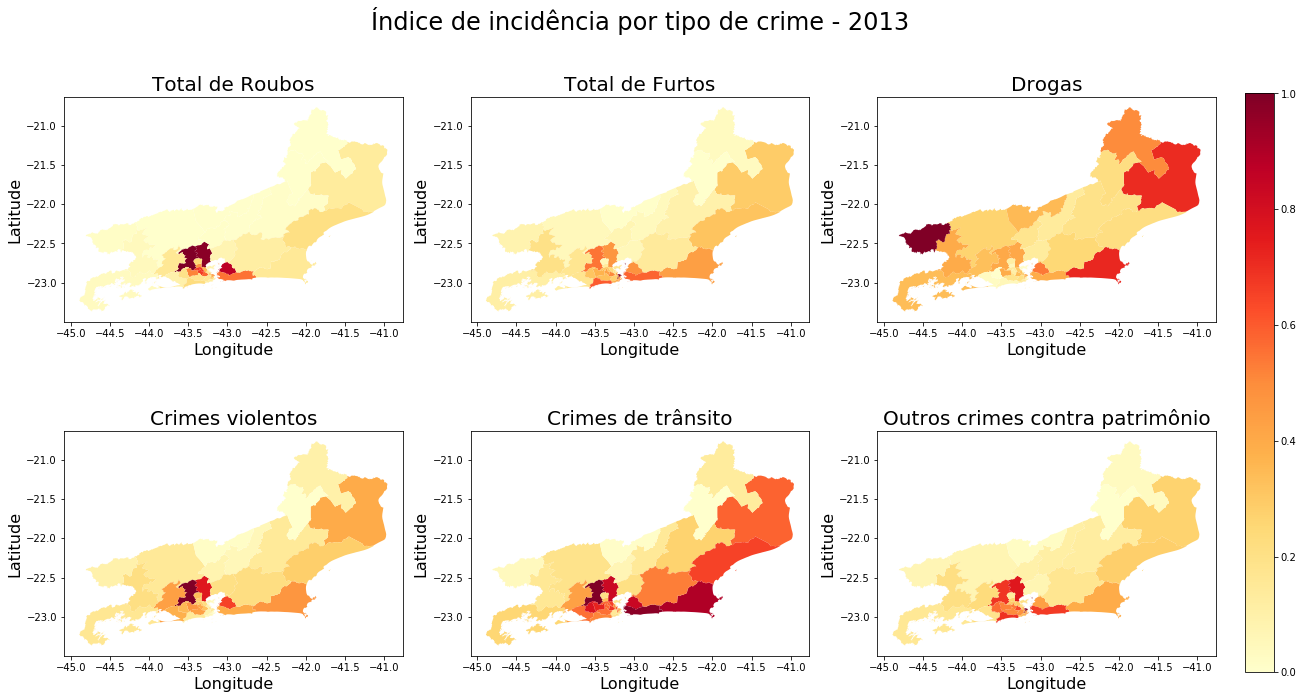

In [24]:
nrows = 2
ncols = 3
k=0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
plt.suptitle('Índice de incidência por tipo de crime - 2013',fontsize=24, y=0.93)
for ax in axes.flat:
        rj_geo_aisp_2013.plot(ax=ax, column=colunas[k],cmap='YlOrRd', legend=False)
        ax.set_ylabel('Latitude', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=16)
        ax.set_title(ylabel[k], fontsize=20)
        k += 1

plt.subplots_adjust(right=0.9, left=0.1, hspace = 0.05)
# Add single colorbar
cax = fig.add_axes([0.92, 0.16, 0.02, 0.67])
sm = plt.cm.ScalarMappable(cmap='YlOrRd')
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.savefig('incidencia_2013')
plt.show();

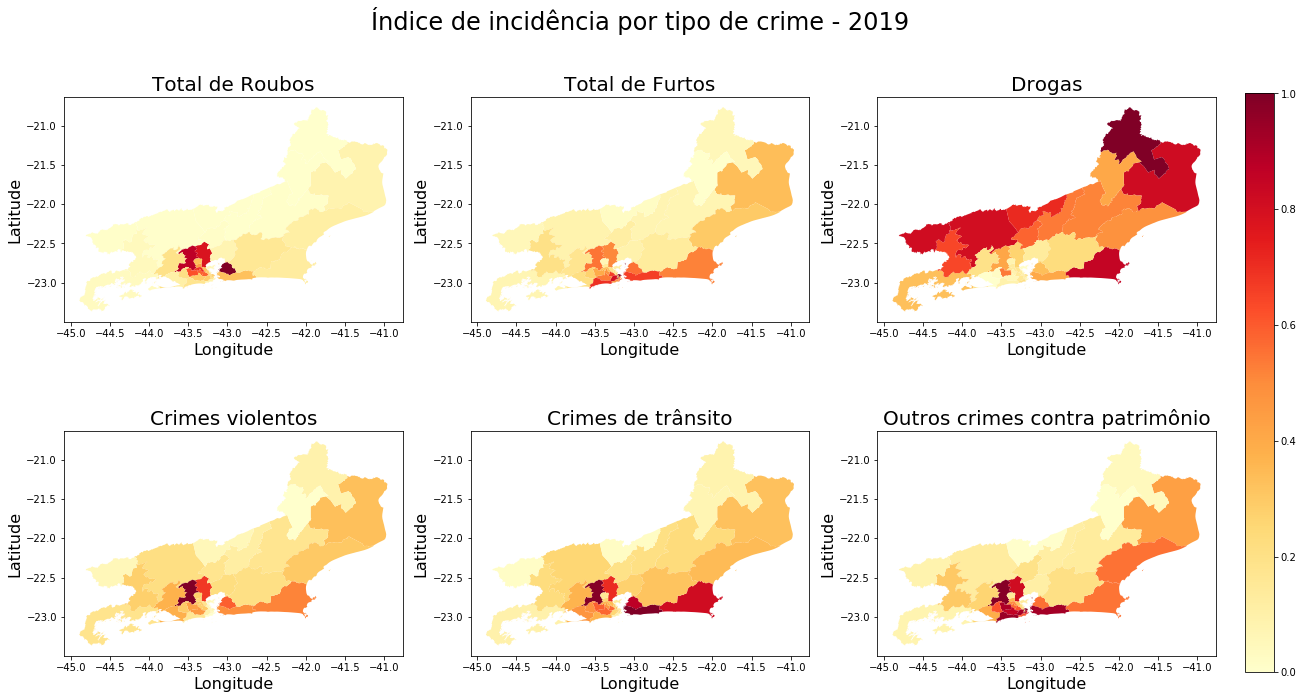

In [25]:
nrows = 2
ncols = 3
k=0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
plt.suptitle('Índice de incidência por tipo de crime - 2019',fontsize=24, y=0.93)
for ax in axes.flat:
        rj_geo_aisp_2019.plot(ax=ax, column=colunas[k],cmap='YlOrRd', legend=False)
        ax.set_ylabel('Latitude', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=16)
        ax.set_title(ylabel[k], fontsize=20)
        k += 1

plt.subplots_adjust(right=0.9, left=0.1, hspace = 0.05)
# Add single colorbar
cax = fig.add_axes([0.92, 0.16, 0.02, 0.67])
sm = plt.cm.ScalarMappable(cmap='YlOrRd')
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.savefig('incidencia_2019')
plt.show();

In [26]:
# Gráfico geopandas com aumento percentual de cada crime por AISP
tot_2019 = df_totais_AISP[df_totais_AISP.vano==2019]
tot_2013 = df_totais_AISP[df_totais_AISP.vano==2013]

tot_2013_19 = tot_2019.merge(tot_2013, how='left', on='AISP',suffixes=('', '_2013'))

for name in colunas:
    tot_2013_19[str(name+'_dif')] = tot_2013_19[name]/tot_2013_19[str(name+'_2013')] - 1
    tot_2013_19.drop([name, str(name+'_2013')],axis=1,inplace=True)
tot_2013_19.rename(columns={"AISP": "aisp"},inplace=True)
tot_2013_19.head()

,aisp,vano,vano_2013,total_roubos_dif,total_furtos_dif,drogas_dif,violentos_dif,transito_dif,outros_ctra_patr_dif
0,2,2019,2013,0.281630,-0.111214,-0.272277,-0.152299,-0.343708,0.485871
1,3,2019,2013,0.681786,-0.041898,-0.616140,-0.239389,-0.391397,-0.197917
2,4,2019,2013,0.203632,-0.442814,-0.648539,-0.510890,-0.590261,-0.380488
3,5,2019,2013,0.106878,-0.244666,-0.542322,-0.395914,-0.640167,-0.174368
4,6,2019,2013,1.840786,0.949086,-0.372294,-0.165491,-0.017886,0.512912


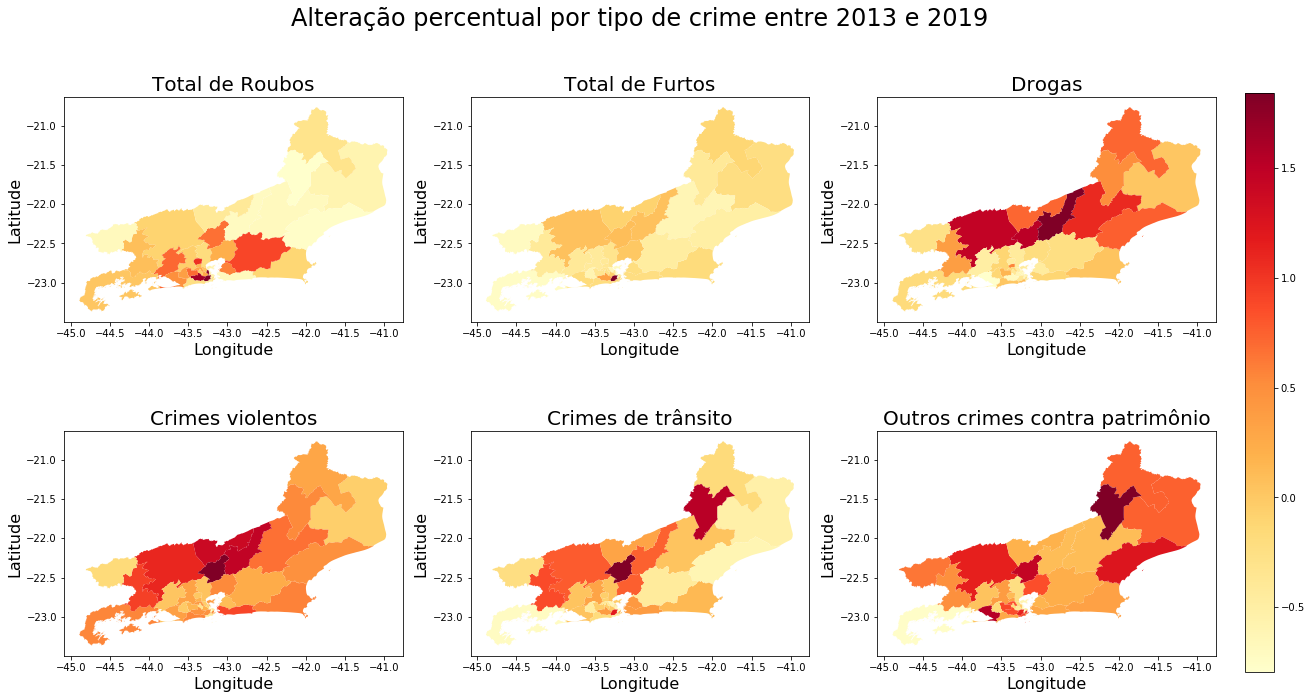

In [27]:
rj_geo_aisp_2013_19 = rj_geo_aisp.merge(tot_2013_19, how='left', on='aisp')
colunas_dif = [i + '_dif' for i in colunas]
nrows = 2
ncols = 3
k=0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,12))
plt.suptitle('Alteração percentual por tipo de crime entre 2013 e 2019',fontsize=24, y=0.93)
for ax in axes.flat:
        rj_geo_aisp_2013_19.plot(ax=ax, column=colunas_dif[k],cmap='YlOrRd', legend=False)
        ax.set_ylabel('Latitude', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=16)
        ax.set_title(ylabel[k], fontsize=20)
        k += 1

plt.subplots_adjust(right=0.9, left=0.1, hspace = 0.05)
# Add single colorbar
cax = fig.add_axes([0.92, 0.16, 0.02, 0.67])
sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=tot_2013_19[colunas_dif].min().min(), vmax=tot_2013_19[colunas_dif].max().max()))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.savefig('alteracao_2013_2019')
plt.show();

In [28]:
# Gerando os números em percentuais para gerar o gráfico de barras empilhadas 100%
df_totais_mes = data.pivot_table(values=colunas, 
                        index=[data.mesano,data.Regiao], 
                        aggfunc=sum)
for k in colunas:
    df_totais_mes[str(k + '_pct')] = df_totais_mes[k]/df_totais_mes[colunas].sum(axis=1)

df_totais_mes.drop(colunas, axis=1, inplace=True)
df_totais_mes = pd.DataFrame(df_totais_mes.stack(), columns=['Total'])
df_totais_mes.index.names = ['mesano', 'Regiao', 'tipo_crime']
df_totais_mes

Total
mesano Regiao             tipo_crime                    
201301 Baixada Fluminense total_roubos_pct      0.302516
                          total_furtos_pct      0.242832
                          drogas_pct            0.057695
                          violentos_pct         0.264248
                          transito_pct          0.071972
...                                                  ...
201912 Interior           total_furtos_pct      0.271724
                          drogas_pct            0.238168
                          violentos_pct         0.240901
                          transito_pct          0.077713
                          outros_ctra_patr_pct  0.081430

[2016 rows x 1 columns]

In [29]:
my_dict = {}
for regiao in df_totais_mes.index.get_level_values(1).unique().tolist():
    my_dict[regiao] = df_totais_mes.loc[(slice(None), [regiao], slice(None)),:]
    my_dict[regiao]["Cumsum"] = my_dict[regiao].groupby(level=["mesano"]).cumsum()
    my_dict[regiao].reset_index(inplace=True)
    my_dict[regiao] = my_dict[regiao][my_dict[regiao].mesano>=201701]
my_dict['Capital'].head(10)

,mesano,Regiao,tipo_crime,Total,Cumsum
288,201701,Capital,total_roubos_pct,0.390697,0.390697
289,201701,Capital,total_furtos_pct,0.318763,0.709460
290,201701,Capital,drogas_pct,0.043872,0.753332
291,201701,Capital,violentos_pct,0.142788,0.896120
292,201701,Capital,transito_pct,0.046355,0.942475
293,201701,Capital,outros_ctra_patr_pct,0.057525,1.000000
294,201702,Capital,total_roubos_pct,0.437656,0.437656
295,201702,Capital,total_furtos_pct,0.312404,0.750061
296,201702,Capital,drogas_pct,0.041320,0.791381
297,201702,Capital,violentos_pct,0.132112,0.923493


In [30]:
df_total_abs = data.pivot_table(values=colunas, 
                        index=[data.mesano,data.Regiao], 
                        aggfunc=sum)
df_total_abs['Total'] = df_total_abs[colunas].sum(axis=1)
df_total_abs.drop(colunas, axis=1, inplace=True)
df_total_abs.reset_index(inplace=True)

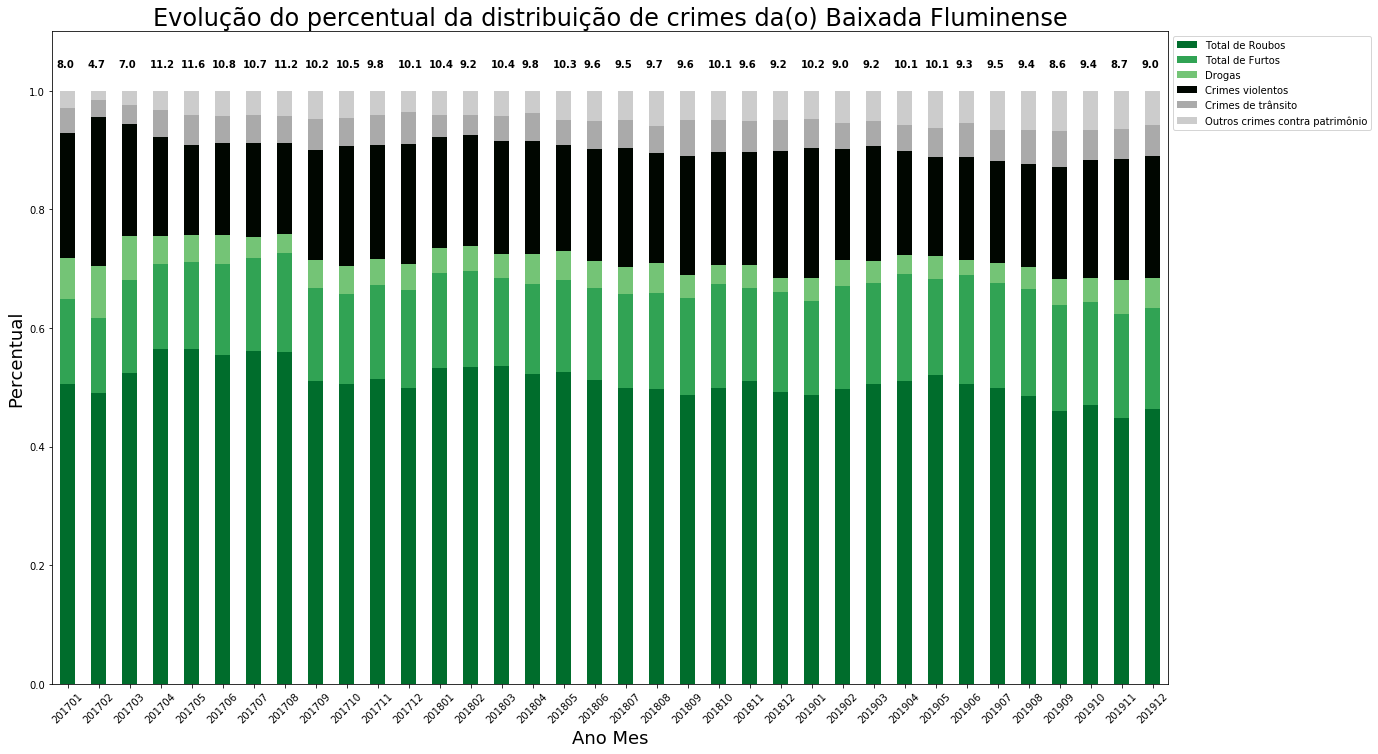

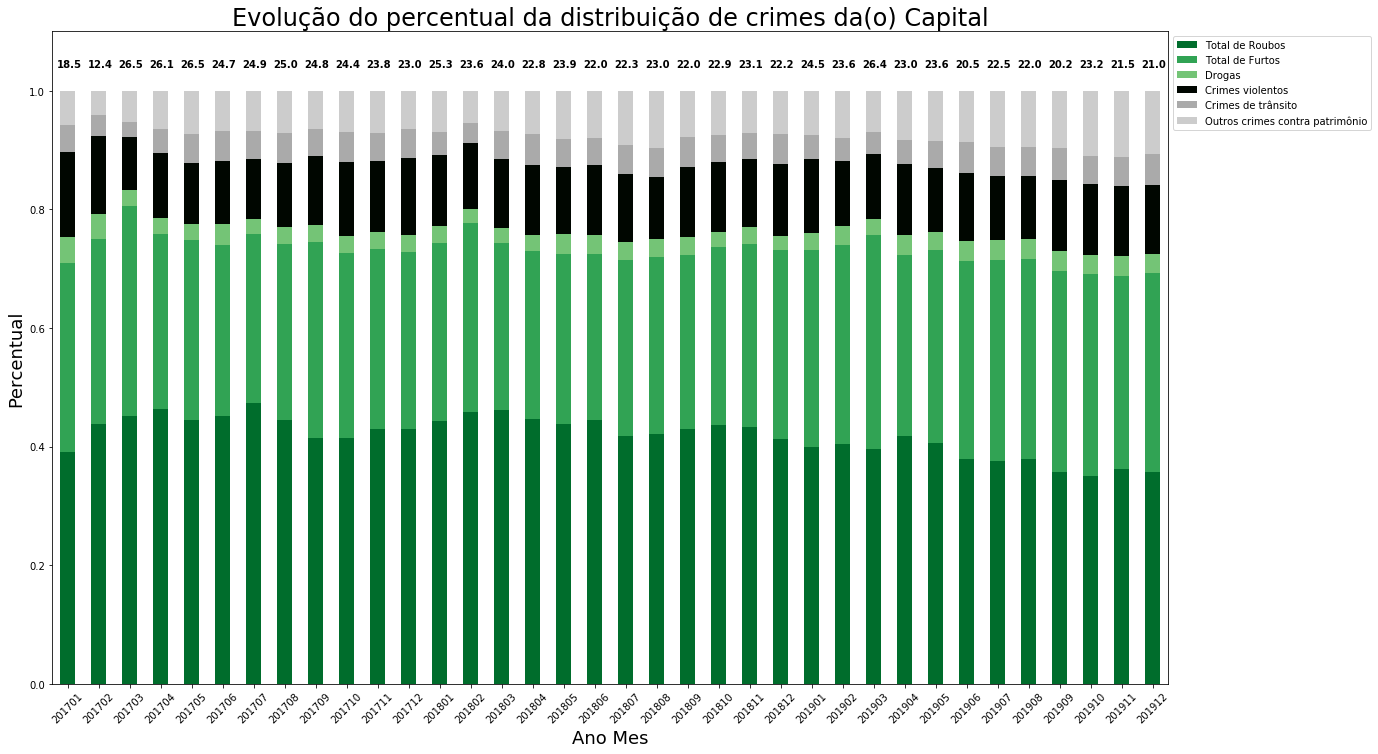

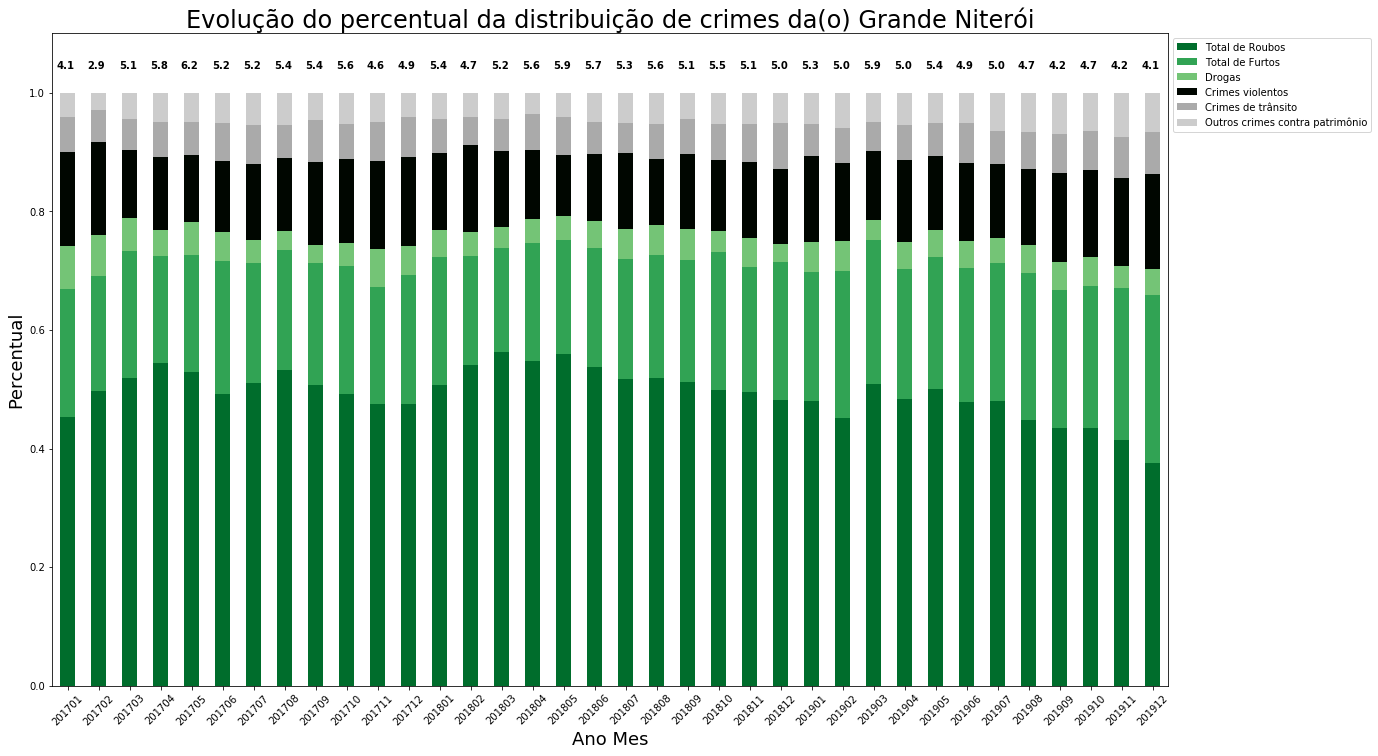

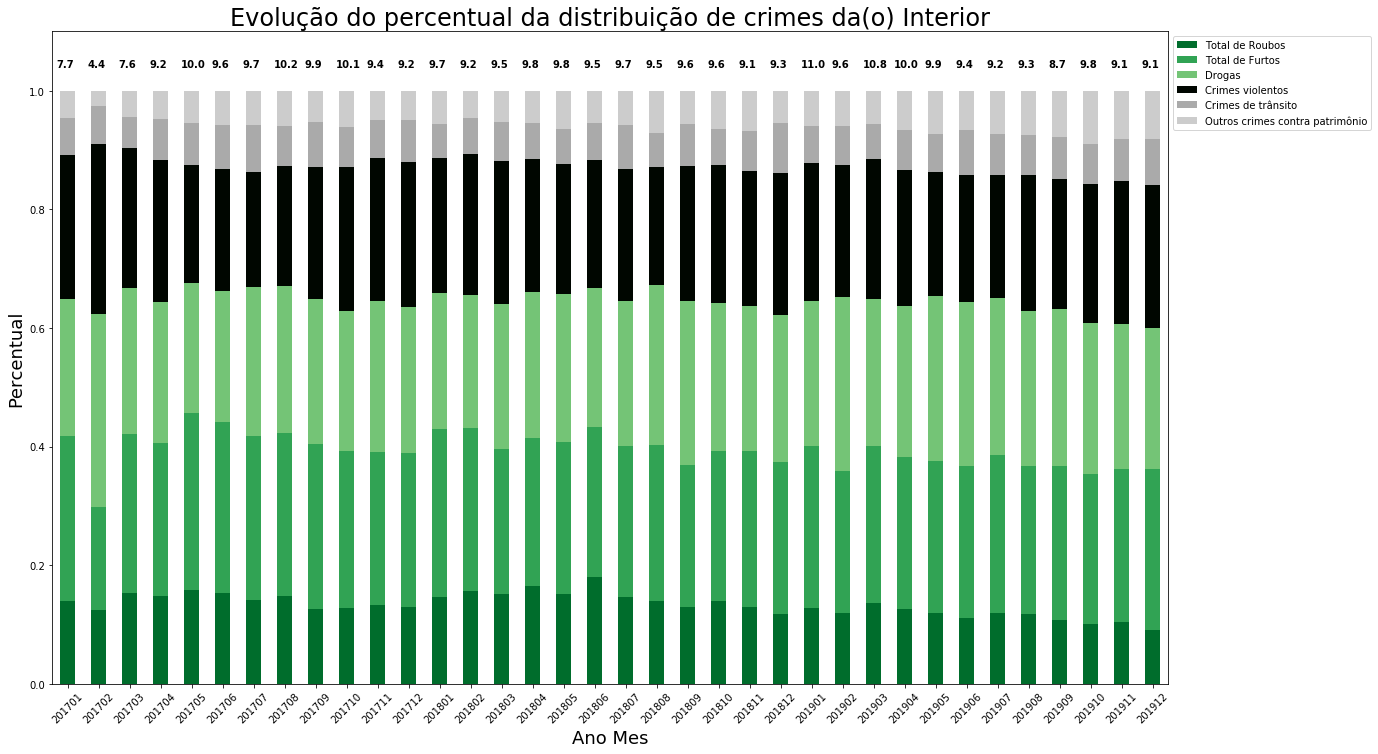

In [31]:
# Gráfico de barras empilhado entre 2017 e 2019 (mes a mes) por Região com a distribuição dos totais de tipos de crimes
# Intuito é ver a evolução durante a intervenção (Fev/18 a Dez/18)
for k in my_dict.keys():
    fn.graf_barras(my_dict, k, df_total_abs, file_name=str('Gráfico barras empilhadas'+k), ylabel=ylabel)